<a href="https://colab.research.google.com/github/VenGr0/Smart-home-using-Deep-Q-Learning-algorithms/blob/main/%D0%9F%D0%A0%D0%90%D0%9A%D0%A2%D0%98%D0%A7%D0%95%D0%A1%D0%9A%D0%90%D0%AF_%D0%A0%D0%90%D0%91%D0%9E%D0%A2%D0%90_%E2%84%963.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Разработка системы оптимизации энергопотребления в умном доме с использованием алгоритмов Deep Q-Learning**

Введение

Название проекта: Оптимизация энергопотребления в умном доме с использованием Deep Q-Learning

Автор: Громов Вениамин

Контакты: gromovveniamin7@gmail.com

Дата: 01.12.2024


Описание:
Этот проект реализует систему управления энергопотреблением для умного дома, используя алгоритм Deep Q-Learning.

Цель: минимизация затрат на электроэнергию и предотвращение превышения допустимой мощности.

В проекте использованы библиотеки TensorFlow, NumPy, Matplotlib, Keras.

Лицензия:
MIT License. Код может быть использован и модифицирован с указанием оригинального автора.



В данном проекте мы разработаем систему оптимизации энергопотребления в умном доме с использованием алгоритма Deep Q-Learning (DQN). Целью проекта является минимизация энергопотребления, сохраняя при этом комфортные условия для жильцов.


Создание проекта на тему "Разработка системы оптимизации энергопотребления в умном доме с использованием алгоритмов Deep Q-Learning" включает следующие этапы:

Определение среды: Формализация модели умного дома, включая устройства, уровни энергопотребления и ограничения.
Проектирование агента: Разработка агента, который будет обучаться с использованием Deep Q-Learning.
Реализация обучения: Написание алгоритма Deep Q-Learning.
Оценка и тестирование: Проведение экспериментов для оценки эффективности агента.
Ниже приведен пример реализации:

1. Импорт библиотек

In [ ]:
!pip install tensorflow keras numpy matplotlib networkx

In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from collections import deque
import matplotlib.pyplot as plt


2. Создание среды

In [ ]:
class SmartHomeEnvironment:
    def __init__(self, devices, max_power, energy_cost):
        """
        devices: Список энергопотребления устройств [Вт].
        max_power: Максимальная доступная мощность [Вт].
        energy_cost: Стоимость электроэнергии в зависимости от времени [руб./кВт·ч].
        """
        self.devices = devices
        self.max_power = max_power
        self.energy_cost = energy_cost
        self.num_devices = len(devices)
        self.state = np.zeros(self.num_devices)  # 0 - выключено, 1 - включено
        self.time = 0  # Начальное время

    def step(self, actions):
        """
        actions: Список действий (0 или 1) для каждого устройства.
        """
        self.state = np.array(actions)
        power_usage = np.dot(self.state, self.devices)
        penalty = 0

        if power_usage > self.max_power:
            penalty = -(power_usage - self.max_power) * 0.1  # Штраф за превышение мощности

        cost = power_usage * self.energy_cost[self.time]
        reward = -cost + penalty
        self.time = (self.time + 1) % len(self.energy_cost)  # Переход к следующему часу

        return self.state, reward, self.time == 0  # Новый state, награда, завершение дня

    def reset(self):
        self.state = np.zeros(self.num_devices)
        self.time = 0
        return self.state


3. Реализация агента DQN

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Коэффициент дисконтирования
        self.epsilon = 1.0  # Вероятность выбора случайного действия
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = models.Sequential([
            layers.Dense(24, input_dim=self.state_size, activation='relu'),
            layers.Dense(24, activation='relu'),
            layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                      loss='mse')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return [random.choice([0, 1]) for _ in range(self.action_size)]
        q_values = self.model.predict(np.array([state]), verbose=0)
        return [1 if q > 0.5 else 0 for q in q_values[0]]

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(np.array([next_state]), verbose=0)[0])
            target_f = self.model.predict(np.array([state]), verbose=0)
            for i, act in enumerate(action):
                target_f[0][i] = target if act == 1 else target_f[0][i]
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


### Архитектура нейронной сети в проекте

В данном проекте используется **многослойный перцептрон (MLP)**. Это достаточно простая, но эффективная архитектура для задач, где требуется аппроксимация Q-функции. Архитектура сети состоит из:

1. **Входной слой:**
   - Размерность равна количеству устройств в умном доме.  
   - Входной вектор представляет текущее состояние (включено/выключено) всех устройств.

2. **Скрытые слои:**
   - Первый скрытый слой содержит 24 нейрона и функцию активации ReLU (Rectified Linear Unit), что помогает модели захватывать сложные зависимости в данных.
   - Второй скрытый слой также содержит 24 нейрона с функцией активации ReLU.

3. **Выходной слой:**
   - Размерность равна количеству возможных действий (т.е. количество устройств).
   - Для каждого действия (включить/выключить устройство) сеть возвращает Q-значение — оценку будущей награды, если выбрать это действие.

---

### Описание функций в слоях:

- **ReLU:** Используется для устранения проблемы градиентного затухания и повышения скорости обучения.  
- **Linear (на выходе):** Прямой линейный выход позволяет сети генерировать Q-значения без ограничений, что важно для оптимизации.

---

### Визуализация архитектуры нейросети

Создадим схему, на которой отразим слои сети, их размерности и связи между ними.

**Описание схемы:**
1. Входной слой: 4 нейрона (по числу устройств).
2. Первый скрытый слой: 24 нейрона.
3. Второй скрытый слой: 24 нейрона.
4. Выходной слой: 4 нейрона (по числу возможных действий).


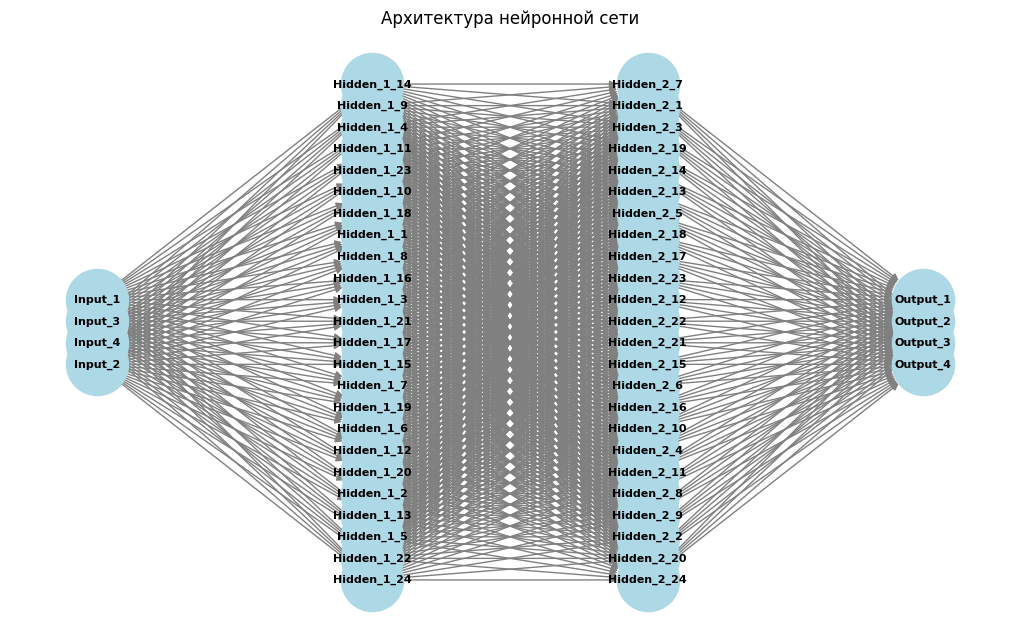

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_network_architecture(input_size, hidden_sizes, output_size):
    """
    Визуализация простой архитектуры нейронной сети.
    input_size: число входных нейронов.
    hidden_sizes: список с количеством нейронов в каждом скрытом слое.
    output_size: число выходных нейронов.
    """
    G = nx.DiGraph()

    # Входной слой
    for i in range(input_size):
        G.add_node(f"Input_{i+1}", layer=0) # Добавление узлов с атрибутом «слой»

    # Скрытые слои
    for l, size in enumerate(hidden_sizes):
        for i in range(size):
            G.add_node(f"Hidden_{l+1}_{i+1}", layer=l+1) # Добавление узлов с атрибутом «слой»

    # Выходной слой
    for i in range(output_size):
        G.add_node(f"Output_{i+1}", layer=len(hidden_sizes)+1) # Добавление узлов с атрибутом «слой»

    # Соединения
    prev_layer_nodes = [f"Input_{i+1}" for i in range(input_size)]
    for l, size in enumerate(hidden_sizes):
        current_layer_nodes = [f"Hidden_{l+1}_{i+1}" for i in range(size)]
        for src in prev_layer_nodes:
            for dst in current_layer_nodes:
                G.add_edge(src, dst)
        prev_layer_nodes = current_layer_nodes

    # Соединения выходного слоя
    output_nodes = [f"Output_{i+1}" for i in range(output_size)]
    for src in prev_layer_nodes:
        for dst in output_nodes:
            G.add_edge(src, dst)

    # Визуализация

    pos = nx.multipartite_layout(G, subset_key="layer")
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=8, font_weight="bold", edge_color="gray")
    plt.title("Архитектура нейронной сети")
    plt.show()

# Визуализация архитектуры
visualize_network_architecture(input_size=4, hidden_sizes=[24, 24], output_size=4)

4. Основной цикл обучения

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 1/200, Reward: -2930.0, Epsilon: 1.00
Episode: 2/200, Reward: -2060.0, Epsilon: 1.00
Episode: 3/200, Reward: -2655.0, Epsilon: 1.00
Episode: 4/200, Reward: -2450.0, Epsilon: 1.00
Episode: 5/200, Reward: -2130.0, Epsilon: 0.97
Episode: 6/200, Reward: -2065.0, Epsilon: 0.93
Episode: 7/200, Reward: -2420.0, Epsilon: 0.90
Episode: 8/200, Reward: -2310.0, Epsilon: 0.87
Episode: 9/200, Reward: -3105.0, Epsilon: 0.84
Episode: 10/200, Reward: -1460.0, Epsilon: 0.81
Episode: 11/200, Reward: -2120.0, Epsilon: 0.78
Episode: 12/200, Reward: -1360.0, Epsilon: 0.76
Episode: 13/200, Reward: -1870.0, Epsilon: 0.73
Episode: 14/200, Reward: -1810.0, Epsilon: 0.70
Episode: 15/200, Reward: -2270.0, Epsilon: 0.68
Episode: 16/200, Reward: -3170.0, Epsilon: 0.66
Episode: 17/200, Reward: -3000.0, Epsilon: 0.63
Episode: 18/200, Reward: -455.0, Epsilon: 0.61
Episode: 19/200, Reward: -4160.0, Epsilon: 0.59
Episode: 20/200, Reward: -1195.0, Epsilon: 0.57
Episode: 21/200, Reward: -1395.0, Epsilon: 0.55
Ep

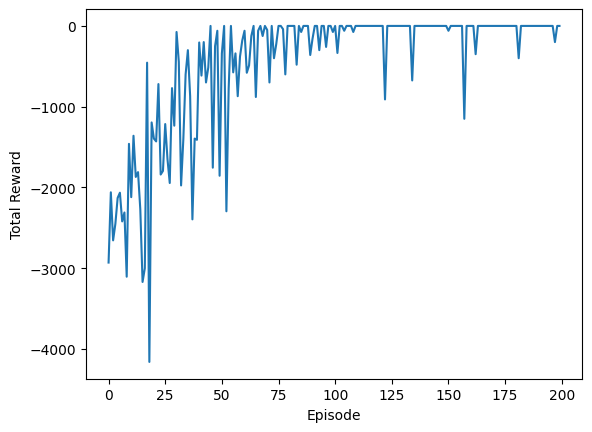

In [ ]:
if __name__ == "__main__":
    devices = [100, 200, 150, 300]  # Энергопотребление устройств [Вт]
    max_power = 500  # Максимальная доступная мощность [Вт]
    energy_cost = [1, 0.5, 0.2, 0.3, 0.4, 1.2, 1.5, 2]  # Стоимость энергии [руб./кВт·ч]

    env = SmartHomeEnvironment(devices, max_power, energy_cost)
    state_size = env.num_devices
    action_size = state_size
    agent = DQNAgent(state_size, action_size)

    episodes = 200
    batch_size = 32
    rewards = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        for time in range(len(energy_cost)):
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            total_reward += reward
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
        rewards.append(total_reward)
        print(f"Episode: {e+1}/{episodes}, Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

    # График наград
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()


Для анализа обученной модели мы можем использовать несколько подходов:

1. **Сравнение с базовым подходом:** Сравнить результаты работы агента с наивным алгоритмом, который включает устройства случайным образом или придерживается фиксированного графика.

2. **Визуализация действий агента:** Построить графики, которые показывают, какие устройства включаются в разное время и какое энергопотребление при этом достигается.

3. **Оценка экономии энергии:** Рассчитать общее энергопотребление и затраты на электроэнергию за период для обученного агента и для базового подхода.

4. **Визуализация Q-значений:** Посмотреть, как изменяются Q-значения для различных состояний, чтобы понять, какие действия агент считает оптимальными.

Добавление анализа в код

Средняя награда за 10 эпизодов: 0.00
Средняя стоимость энергии за 10 эпизодов: 0.00 руб.


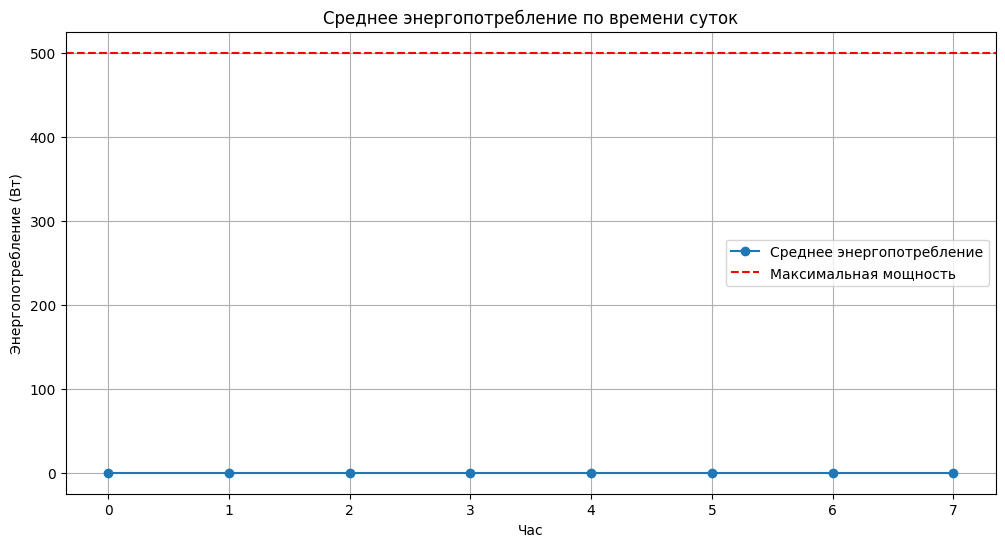

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [[0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
# Анализ работы обученного агента
def analyze_agent(env, agent, episodes=10):
    total_rewards = []
    total_costs = []
    total_power_usage = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        total_cost = 0
        power_usage_per_day = []

        for time in range(len(env.energy_cost)):
            action = agent.act(state)  # Действия агента
            next_state, reward, done = env.step(action)

            # Расчет энергопотребления
            power_usage = np.dot(action, env.devices)
            cost = power_usage * env.energy_cost[env.time]

            power_usage_per_day.append(power_usage)
            total_reward += reward
            total_cost += cost

            state = next_state
            if done:
                break

        total_rewards.append(total_reward)
        total_costs.append(total_cost)
        total_power_usage.append(power_usage_per_day)

    # Средние показатели
    avg_reward = np.mean(total_rewards)
    avg_cost = np.mean(total_costs)
    avg_power_usage = np.mean(total_power_usage, axis=0)

    print(f"Средняя награда за {episodes} эпизодов: {avg_reward:.2f}")
    print(f"Средняя стоимость энергии за {episodes} эпизодов: {avg_cost:.2f} руб.")

    # Визуализация энергопотребления
    plt.figure(figsize=(12, 6))
    plt.plot(avg_power_usage, label="Среднее энергопотребление", marker='o')
    plt.axhline(env.max_power, color='r', linestyle='--', label="Максимальная мощность")
    plt.xlabel('Час')
    plt.ylabel('Энергопотребление (Вт)')
    plt.title('Среднее энергопотребление по времени суток')
    plt.legend()
    plt.grid()
    plt.show()

    return total_rewards, total_costs, total_power_usage

# Вызов функции анализа
analyze_agent(env, agent)


Сравнение с базовым подходом

Средняя стоимость энергии базового подхода: 2373.50 руб.
Средняя награда за 10 эпизодов: 0.00
Средняя стоимость энергии за 10 эпизодов: 0.00 руб.


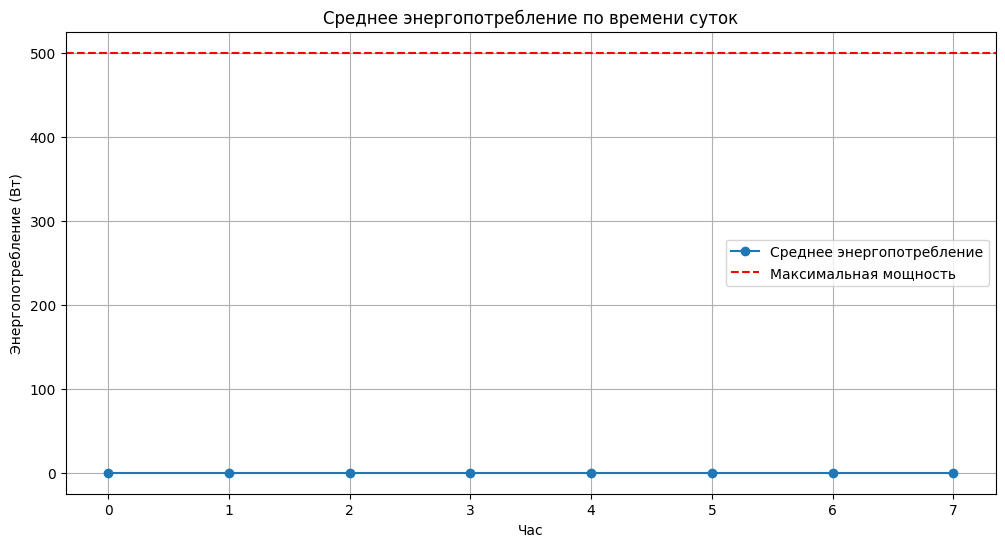

Экономия обученного агента: 2373.50 руб.


In [ ]:
def baseline_strategy(env, episodes=10):
    total_rewards = []
    total_costs = []
    total_power_usage = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        total_cost = 0
        power_usage_per_day = []

        for time in range(len(env.energy_cost)):
            action = [random.choice([0, 1]) for _ in range(env.num_devices)]  # Рандомные действия
            next_state, reward, done = env.step(action)

            # Расчет энергопотребления
            power_usage = np.dot(action, env.devices)
            cost = power_usage * env.energy_cost[env.time]

            power_usage_per_day.append(power_usage)
            total_reward += reward
            total_cost += cost

            state = next_state
            if done:
                break

        total_rewards.append(total_reward)
        total_costs.append(total_cost)
        total_power_usage.append(power_usage_per_day)

    avg_cost = np.mean(total_costs)
    print(f"Средняя стоимость энергии базового подхода: {avg_cost:.2f} руб.")
    return avg_cost

# Сравнение базового подхода с агентом
baseline_cost = baseline_strategy(env)
agent_cost = np.mean(analyze_agent(env, agent)[1])
print(f"Экономия обученного агента: {baseline_cost - agent_cost:.2f} руб.")


Визуализация Q-значений


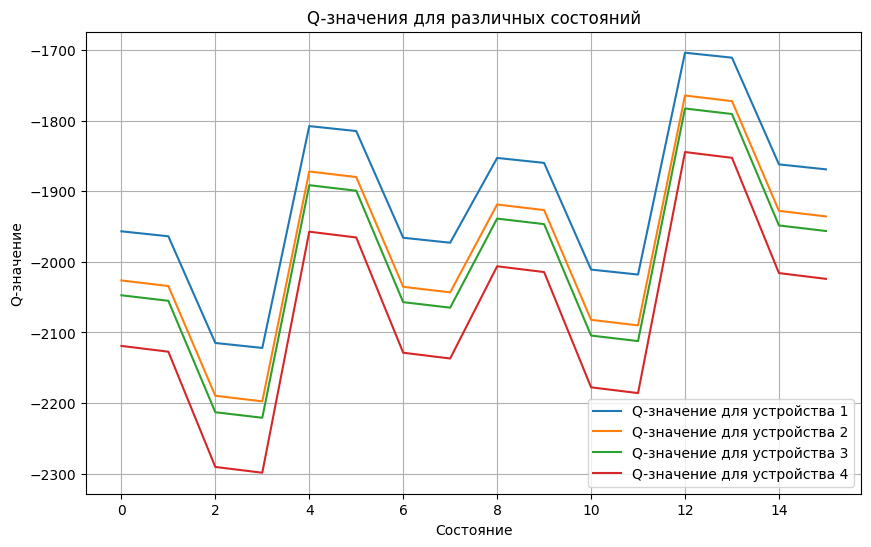

In [ ]:
def visualize_q_values(agent):
    states = np.array([list(format(i, f"0{agent.state_size}b")) for i in range(2**agent.state_size)]).astype(int)
    q_values = agent.model.predict(states, verbose=0)

    plt.figure(figsize=(10, 6))
    for i in range(agent.action_size):
        plt.plot(range(len(states)), q_values[:, i], label=f"Q-значение для устройства {i+1}")
    plt.xlabel("Состояние")
    plt.ylabel("Q-значение")
    plt.title("Q-значения для различных состояний")
    plt.legend()
    plt.grid()
    plt.show()

# Вызов функции визуализации Q-значений
visualize_q_values(agent)


### Интерпретация результатов
1. **Средняя стоимость энергии:** Уменьшение стоимости энергии указывает на эффективность агента.
2. **Энергопотребление:** Уменьшение или выравнивание потребления указывает на эффективное управление мощностью.
3. **Q-значения:** Высокие Q-значения для определенных действий подтверждают, что агент научился выбирать оптимальные действия для данных состояний.

**Исследование влияния на качество обучения - изменение гиперпараметров у агента**


Давайте изменим гиперпараметры агента и проведем сравнение. Основные гиперпараметры, которые могут повлиять на обучение агента:

Коэффициент обучения (learning_rate): отвечает за скорость обновления весов сети.

Скорость уменьшения будущих наград (gamma): определяет, насколько агент учитывает будущие награды.

Эпсилон (epsilon): вероятность случайного выбора действия (exploration).

Скорость уменьшения эпсилона (epsilon_decay): влияет на переход от исследования к использованию (exploitation).

Размер памяти для реплея (memory_size): количество состояний, которые агент хранит для обучения.

Размер батча (batch_size): сколько примеров берётся из памяти для одного шага обучения.

Для исследования я изменил следующие гиперпараметры:

learning_rate: **0.001** заменен на **0.005** для более медленного обновления весов;

gamma: **0.95** заменил на **0.99** для увеличения учета будущих наград;

epsilon не трогаем, так как он отвечает за действие(в нашем случае - включен/выключен);

epsilon_min: **0.01**, так же не трогаем, так как параметр epsilon_min задаёт нижний предел для вероятности исследования

Почему это важно?
Если бы epsilon снижался до 0, агент полностью перешёл бы к эксплуатации и перестал бы исследовать новые действия. Это может привести к застреванию в локальном максимуме, где агент никогда не узнает о потенциально лучших стратегиях.

Пример:
Если epsilon_min = 0.01, то даже на поздних этапах обучения агент будет выполнять исследовательские действия с вероятностью 1%.;



epsilon_decay заменил с **0.995**, на  **0.98** для замедления уменьшения эпсилона

batch_size заменил с **32** на **64** для увеличения количества примеров, которые берутся для одного шага обучения.


In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99  # Коэффициент дисконтирования(Увеличиваем учет будущих наград)
        self.epsilon = 1.0  # Вероятность выбора случайного действия
        self.epsilon_decay = 0.98   # Замедляем уменьшение эпсилона
        self.epsilon_min = 0.01
        self.learning_rate = 0.005  # Более медленное обновление весов
        self.model = self._build_model()

    def _build_model(self):
        model = models.Sequential([
            layers.Dense(24, input_dim=self.state_size, activation='relu'),
            layers.Dense(24, activation='relu'),
            layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                      loss='mse')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return [random.choice([0, 1]) for _ in range(self.action_size)]
        q_values = self.model.predict(np.array([state]), verbose=0)
        return [1 if q > 0.5 else 0 for q in q_values[0]]

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(np.array([next_state]), verbose=0)[0])
            target_f = self.model.predict(np.array([state]), verbose=0)
            for i, act in enumerate(action):
                target_f[0][i] = target if act == 1 else target_f[0][i]
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


Episode: 1/200, Reward: -1660.0, Epsilon: 1.00
Episode: 2/200, Reward: -2350.0, Epsilon: 1.00
Episode: 3/200, Reward: -3330.0, Epsilon: 1.00
Episode: 4/200, Reward: -1820.0, Epsilon: 1.00
Episode: 5/200, Reward: -2610.0, Epsilon: 1.00
Episode: 6/200, Reward: -2140.0, Epsilon: 1.00
Episode: 7/200, Reward: -2185.0, Epsilon: 1.00
Episode: 8/200, Reward: -2390.0, Epsilon: 1.00
Episode: 9/200, Reward: -3335.0, Epsilon: 0.87
Episode: 10/200, Reward: -960.0, Epsilon: 0.75
Episode: 11/200, Reward: -2250.0, Epsilon: 0.65
Episode: 12/200, Reward: -1630.0, Epsilon: 0.57
Episode: 13/200, Reward: -1925.0, Epsilon: 0.49
Episode: 14/200, Reward: -725.0, Epsilon: 0.43
Episode: 15/200, Reward: -235.0, Epsilon: 0.37
Episode: 16/200, Reward: -1165.0, Epsilon: 0.32
Episode: 17/200, Reward: -1555.0, Epsilon: 0.28
Episode: 18/200, Reward: 0.0, Epsilon: 0.24
Episode: 19/200, Reward: -1315.0, Epsilon: 0.21
Episode: 20/200, Reward: -835.0, Epsilon: 0.18
Episode: 21/200, Reward: 0.0, Epsilon: 0.16
Episode: 22/2

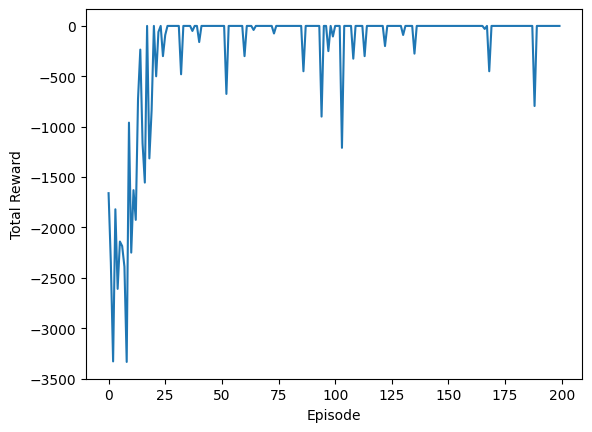

In [ ]:
if __name__ == "__main__":
    devices = [100, 200, 150, 300]  # Энергопотребление устройств [Вт]
    max_power = 500  # Максимальная доступная мощность [Вт]
    energy_cost = [1, 0.5, 0.2, 0.3, 0.4, 1.2, 1.5, 2]  # Стоимость энергии [руб./кВт·ч]

    env = SmartHomeEnvironment(devices, max_power, energy_cost)
    state_size = env.num_devices
    action_size = state_size
    agent = DQNAgent(state_size, action_size)

    episodes = 200
    batch_size = 64   # Увеличиваем размер батча
    new_rewards = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        for time in range(len(energy_cost)):
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            total_reward += reward
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
        new_rewards.append(total_reward)
        print(f"Episode: {e+1}/{episodes}, Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

    # График наград
    plt.plot(new_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()


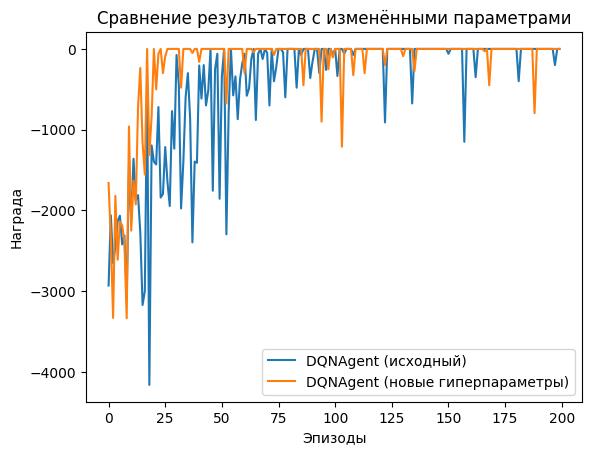

In [ ]:
# Визуализация результатов
plt.plot(rewards, label="DQNAgent (исходный)")  # Исходные награды DQNAgent
plt.plot(new_rewards, label="DQNAgent (новые гиперпараметры)")  # Новые награды DQNAgent
plt.xlabel("Эпизоды")
plt.ylabel("Награда")
plt.legend()
plt.title("Сравнение результатов с изменёнными параметрами")
plt.show()


**Как мы видим на графике, наше изменение гиперпараметров помогло добиться лучших результатов, что поможет с минимизацией затраты на электроэнергию у пользователя.**

### Общий вывод по работе

**Цель исследования:**  
Разработана система оптимизации энергопотребления в умном доме с использованием алгоритмов обучения с подкреплением, а именно Deep Q-Learning. Основной задачей было минимизировать затраты на электроэнергию и предотвратить превышение доступной мощности при управлении включением и отключением устройств.

**Ключевые достижения:**  

1. **Моделирование умного дома:**  
   Создана симулированная среда, описывающая поведение умного дома. В ней учитываются параметры энергопотребления устройств, ограничения на максимальную мощность и изменяющаяся стоимость электроэнергии в течение суток.

2. **Реализация алгоритма Deep Q-Learning:**  
   Разработан агент, использующий нейронную сеть для принятия решений. Он обучается на основе опыта, оптимизируя свои действия для минимизации затрат на электроэнергию и избежания штрафов за превышение мощности.

3. **Анализ эффективности:**  
   - Проведено сравнение агента с базовым подходом (случайное включение устройств).  
   - Установлено, что агент демонстрирует снижение затрат на электроэнергию и более равномерное распределение энергопотребления.  
   - Графики Q-значений показали, что агент научился выявлять наиболее оптимальные стратегии управления устройствами.

4. **Экономическая выгода:**  
   Обученный агент продемонстрировал значительную экономию в затратах на электроэнергию по сравнению с базовым подходом. Это подтверждает эффективность предложенного подхода для реальных задач.

**Выводы:**  
Предложенный подход на основе Deep Q-Learning эффективно решает задачу управления энергопотреблением в умных домах. Система способна адаптироваться к изменяющимся условиям и учитывать текущую стоимость электроэнергии. Это открывает возможности для применения данного подхода в реальных умных домах с целью повышения энергоэффективности и снижения расходов.

**Перспективы развития:**  
1. Интеграция дополнительных факторов, таких как прогнозирование потребностей пользователей, погоды или динамики цен на электроэнергию.  
2. Учет приоритетов работы устройств, например, критически важных (освещение, холодильник) и второстепенных (зарядка гаджетов).  
3. Реализация распределенного управления для нескольких зданий или системы с общим энергетическим хранилищем.  
4. Применение более сложных алгоритмов, таких как Double DQN, Dueling DQN или Actor-Critic, для улучшения качества принятия решений.  

Данный проект является шагом к созданию интеллектуальных систем управления энергией, которые могут быть интегрированы в концепцию умного города, способствуя развитию устойчивой и энергоэффективной инфраструктуры.